In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from itertools import product
import kb_python.utils as kb_utils
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from tqdm import tqdm
TQDM_BAR_FORMAT = (
    "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
)

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [2]:
virus_fasta = "/home/laura/projects/virus-watch-data/virus_ref/uniques_noduplicates.fa"
virus_t2g = "/home/laura/projects/virus-watch-data/virus_ref/nodup_clu_t2g.txt"
u_tax_dp = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

out_folder = "/home/laura/projects/virus-watch-data/benchmarking/remove_target_from_ref"

kallisto = "/home/laura/projects/kallisto/build/src/kallisto"
bustools = "/home/laura/projects/bustools/build/src/bustools"

Define targets to be removed from index:

In [315]:
# records = SeqIO.parse("/home/laura/projects/virus-watch-data/benchmarking/mutations/kraken_test_nn.fa", "fasta")

# targets = []
# for record in records:
#     targets.append(record.id)
    
# targets

Create new fasta excluding all sequences associated with these species:

In [8]:
taxmap = pd.read_csv(u_tax_dp)
taxmap

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


In [317]:
# def flatten(l):
#     return [item for sublist in l for item in sublist]

In [318]:
# targets_all = []
# for id_ in targets:
#     targets_all.append(taxmap[taxmap["rep_ID"] == id_]["ID"].values)
    
# targets_all = flatten(targets_all)

In [319]:
targets_all = taxmap[taxmap["genus"].str.contains("Ebolavirus")]["ID"].values

In [320]:
test_fasta = f"{out_folder}/uniques_nodup_targets_removed.fa"

In [321]:
%%time
records = SeqIO.parse(virus_fasta, "fasta")

with open(test_fasta, "w") as new_fasta:
    for record in records:
        if record.id not in targets_all:
            new_fasta.write(">" + record.id + "\n")
            new_fasta.write(str(record.seq) + "\n")

CPU times: user 3.69 s, sys: 57.6 ms, total: 3.74 s
Wall time: 3.83 s


Generate index with new fasta:

In [322]:
virus_index = f"{out_folder}/uniques_nodup_targets_removed.idx"

In [323]:
!$kallisto index \
    -t 12 \
    --aa \
    -i $virus_index \
    $test_fasta


[build] loading fasta file /home/laura/projects/virus-watch-data/benchmarking/remove_target_from_ref/uniques_nodup_targets_removed.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37640331
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7877361
CompactedDBG::filter(): Processed 87606558 k-mers in 296482 reads
CompactedDBG::filter(): Found 37506216 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 257308
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::con

Align fasta with nucleotide sequences of species removed from index:

In [324]:
# nn_fasta = "/home/laura/projects/virus-watch-data/benchmarking/mutations/kraken_test_nn.fa"
# nn_fasta_R1 = "/home/laura/projects/virus-watch-data/benchmarking/mutations/kraken_test_nn_R1.fa"

nn_fasta = "/home/laura/projects/virus-watch-data/PRJNA665227/raw/SRR12698539_2_extracted_u10.fa"

In [325]:
# # Create a fake barcode for each sequence in the PalmDB
# barcodes = [''.join(i) for i in product(["A", "C", "G", "T"], repeat=3)]

# print(len(barcodes))

In [326]:
# # Create fake R1 file with barcodes
# virus_ids = []
# with open(nn_fasta_R1, "w") as fake_R1:
#     for (barcode, record) in zip(barcodes[:30], SeqIO.parse(nn_fasta, "fasta")):
#         fake_R1.write(">" + record.id + "\n")
#         fake_R1.write(barcode + "\n")
#         virus_ids.append(record.id)

In [327]:
# bc2virus = pd.DataFrame()
# bc2virus["virus_ID"] = virus_ids
# bc2virus["barcode"] = barcodes[:30]
# bc2virus

In [328]:
# # Align with fake barcodes so we can see which sequence was aligned to which taxonomy
# !$kallisto bus \
#         -i $virus_index \
#         -o $out_folder/kallisto \
#         --aa \
#         -x 0,0,0:0,0,3:1,0,0 \
#         -t 5 \
#         $nn_fasta_R1 $nn_fasta

!$kallisto bus \
        -i $virus_index \
        -o $out_folder/kallisto \
        --aa \
        -x bulk \
        -t 5 \
        $nn_fasta

!$bustools sort -o $out_folder/kallisto/output_sorted.bus $out_folder/kallisto/output.bus

!$bustools count \
    --genecounts \
    --cm \
    -o $out_folder/kallisto/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/kallisto/matrix.ec \
    -t $out_folder/kallisto/transcripts.txt \
    $out_folder/kallisto/output_sorted.bus


[index] k-mer length: 31
[index] number of targets: 296,482
[index] number of k-mers: 37,539,216
[quant] running in single-end mode
[quant] will process file 1: /home/laura/projects/virus-watch-data/PRJNA665227/raw/SRR12698539_2_extracted_u10.fa
[quant] finding pseudoalignments for all files ... done
[quant] processed 676 reads, 127 reads pseudoaligned

 all fits in buffer
Read in 127 BUS records
reading time 0s
sorting time 0s
writing time 0s


# Same but remove up to virus family

In [329]:
targets_all = taxmap[taxmap["family"].str.contains("Filoviridae")]["ID"].values

In [330]:
test_fasta = f"{out_folder}/uniques_nodup_targets_removed_3.fa"

In [331]:
%%time
records = SeqIO.parse(virus_fasta, "fasta")

with open(test_fasta, "w") as new_fasta:
    for record in records:
        if record.id not in targets_all:
            new_fasta.write(">" + record.id + "\n")
            new_fasta.write(str(record.seq) + "\n")

CPU times: user 4.02 s, sys: 51.9 ms, total: 4.07 s
Wall time: 4.16 s


Generate index with new fasta:

In [332]:
virus_index = f"{out_folder}/uniques_nodup_targets_removed_3.idx"

In [333]:
!$kallisto index \
    -t 12 \
    --aa \
    -i $virus_index \
    $test_fasta


[build] loading fasta file /home/laura/projects/virus-watch-data/benchmarking/remove_target_from_ref/uniques_nodup_targets_removed_3.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37637384
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7876665
CompactedDBG::filter(): Processed 87601434 k-mers in 296466 reads
CompactedDBG::filter(): Found 37504068 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 257288
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::c

Align fasta with nucleotide sequences of species removed from index:

In [334]:
nn_fasta = "/home/laura/projects/virus-watch-data/PRJNA665227/raw/SRR12698539_2_extracted_u10.fa"

In [335]:
!$kallisto bus \
        -i $virus_index \
        -o $out_folder/kallisto3 \
        --aa \
        -x bulk \
        -t 5 \
        $nn_fasta

!$bustools sort -o $out_folder/kallisto3/output_sorted.bus $out_folder/kallisto3/output.bus

!$bustools count \
    --genecounts \
    --cm \
    -o $out_folder/kallisto3/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/kallisto3/matrix.ec \
    -t $out_folder/kallisto3/transcripts.txt \
    $out_folder/kallisto3/output_sorted.bus


[index] k-mer length: 31
[index] number of targets: 296,466
[index] number of k-mers: 37,536,591
[quant] running in single-end mode
[quant] will process file 1: /home/laura/projects/virus-watch-data/PRJNA665227/raw/SRR12698539_2_extracted_u10.fa
[quant] finding pseudoalignments for all files ... done
[quant] processed 676 reads, 142 reads pseudoaligned

 all fits in buffer
Read in 142 BUS records
reading time 0s
sorting time 0s
writing time 0s


### Load results and see which taxonomies the sequences were aligned to

Load data where ebola genera were removed:

In [15]:
# Filepath to counts
X = f"{out_folder}/kallisto/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/kallisto/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/kallisto/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 1 × 99221

In [337]:
# Add sequence IDs based on fake barcode
# adata.obs = adata.obs.merge(bc2virus, on="barcode").set_index("barcode")

In [338]:
ids_seen = adata.var[nd(adata.X.sum(axis=0) > 0)].index.values
ids_seen

array(['u102797', 'u133417'], dtype=object)

In [339]:
taxmap[taxmap["rep_ID"].isin(ids_seen)]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
218192,u102797,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218193,u1158,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218194,u15480,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218195,u15788,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218196,u20644,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218197,u21217,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218198,u424,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218199,u444,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
237814,u133417,u133417,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,.,.,-ssRNA
237815,u14593,u133417,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,.,.,-ssRNA


Load data where ebola species were removed:

In [5]:
# Filepath to counts
X = f"{out_folder}/kallisto2/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/kallisto2/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/kallisto2/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata2 = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata2

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 1 × 99222

In [6]:
ids_seen2 = adata2.var[nd(adata2.X.sum(axis=0) > 0)].index.values
ids_seen2

array(['u14834', 'u102797'], dtype=object)

In [9]:
taxmap[taxmap["rep_ID"].isin(ids_seen2)]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
32024,u14834,u14834,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,.,-ssRNA
32025,u190559,u14834,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,.,-ssRNA
218192,u102797,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218193,u1158,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218194,u15480,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218195,u15788,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218196,u20644,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218197,u21217,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218198,u424,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA
218199,u444,u102797,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus,-ssRNA


Load data where ebola family were removed:

In [10]:
# Filepath to counts
X = f"{out_folder}/kallisto3/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/kallisto3/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/kallisto3/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata3 = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata3

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 1 × 99218

In [11]:
ids_seen3 = adata3.var[nd(adata3.X.sum(axis=0) > 0)].index.values
ids_seen3

array(['u11295'], dtype=object)

In [12]:
taxmap[taxmap["rep_ID"].isin(ids_seen3)]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
29331,u11295,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29332,u17489,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29333,u2062,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29334,u20957,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29335,u27987,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29336,u44973,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29337,u6240,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA
29338,u9587,u11295,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Paraavulavirus,Avian paraavulavirus 4,-ssRNA


# Plot bar plots

In [37]:
# total number of sequences
total = 676

In [56]:
colors = ["#003049", "#4b8eb3", "#8fc0de"]

In [83]:
def barplot(tax_level, expected_tax):
    fig, ax = plt.subplots(figsize=(5,7))
    fontsize=18
    
    correct = adata2[:, adata2.var.index.isin(taxmap[taxmap[tax_level] == expected_tax]["rep_ID"].unique())].X.sum()
    # incorrect = adata2.X.sum() - correct
    ax.bar(0, correct, color=colors[0], edgecolor="black")
    not_aligned = total - correct
    if tax_level == "phylum":
        ax.bar(0, not_aligned, bottom=correct, color="white", edgecolor="black", hatch="/")
        
    if tax_level == "phylum":
        ax.text(0, correct-correct/2, str(int(correct)), fontsize=fontsize, ha="center", color="white")
    else:
        if correct > 0:
            ax.text(0, correct+10, str(int(correct)), fontsize=fontsize, ha="center")


    total_aligned = 145
    correct = adata[:, adata.var.index.isin(taxmap[taxmap[tax_level] == expected_tax]["rep_ID"].unique())].X.sum()
    # incorrect = adata.X.sum() - correct
    # multimapped = total_aligned - adata.X.sum()
    ax.bar(1, correct, color=colors[1], edgecolor="black")
    not_aligned = total - correct
    if tax_level == "phylum":
        ax.bar(1, not_aligned, bottom=correct, color="white", edgecolor="black", hatch="/")
    if tax_level == "phylum":
        ax.text(1, correct-correct/2, str(int(correct)), fontsize=fontsize, ha="center")
    else:
        if correct > 0:
            ax.text(1, correct+10, str(int(correct)), fontsize=fontsize, ha="center")
    # ax.bar(1, incorrect, bottom=correct, color="white", edgecolor="black", hatch="+")
    # ax.bar(1, multimapped, bottom=incorrect+correct, color="white", edgecolor="black", hatch="//")

    correct = adata3[:, adata3.var.index.isin(taxmap[taxmap[tax_level] == expected_tax]["rep_ID"].unique())].X.sum()
    # incorrect = adata3.X.sum() - correct
    not_aligned = total - correct
    if tax_level == "phylum":
        ax.bar(2, not_aligned, bottom=correct, color="white", edgecolor="black", hatch="/")
    ax.bar(2, correct, color=colors[2], edgecolor="black")
    if tax_level == "phylum":
        ax.text(2, correct-correct/2, str(int(correct)), fontsize=fontsize, ha="center")
    else:
        if correct > 0:
            ax.text(2, correct+10, str(int(correct)), fontsize=fontsize, ha="center")
    # ax.bar(2, incorrect, bottom=correct, color="white", edgecolor="black", hatch="+")
    
    ax.axhline(total, color="black", ls="--")

    # x_labels = ["All Ebolavirus\nspecies excluded", "All Ebolavirus\ngenera excluded", "All Filoviridae\nexcluded"]
    # ax.set_xticks([0,1,2], x_labels)
    ax.set_xticks([])
    
    if tax_level == "phylum":
        ax.set_ylabel("Counts", fontsize=fontsize)
    else:
        ax.set_yticks([0,100,200,300,400,500,600,700], ["","","","","","","",""])
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.tick_params(axis="both", labelsize=fontsize)

    ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
    ax.set_axisbelow(True)

    plt.savefig(f"figures/targets_removed_ontarget_{tax_level}.png", dpi=300, bbox_inches="tight")

    fig.show()

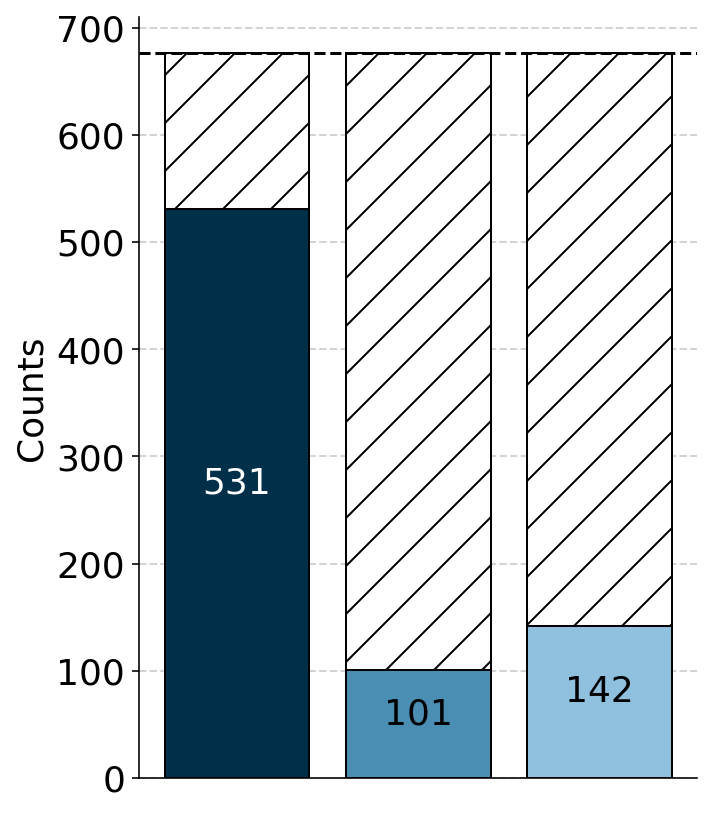

In [84]:
barplot("phylum", "Negarnaviricota")

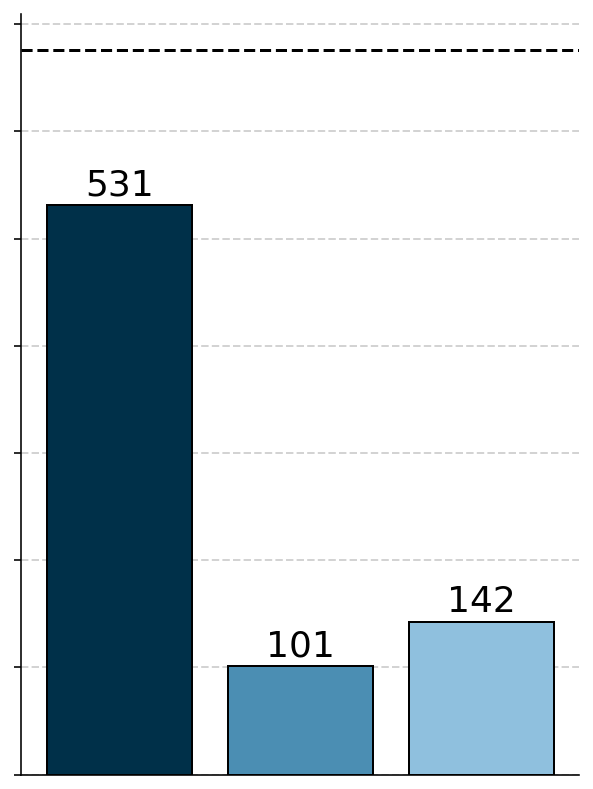

In [59]:
barplot("class", "Monjiviricetes")

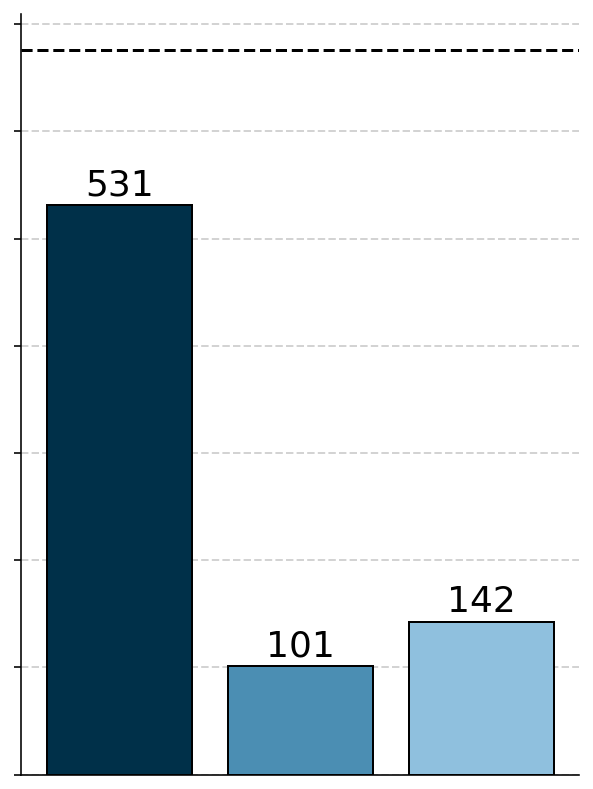

In [60]:
barplot("order", "Mononegavirales")

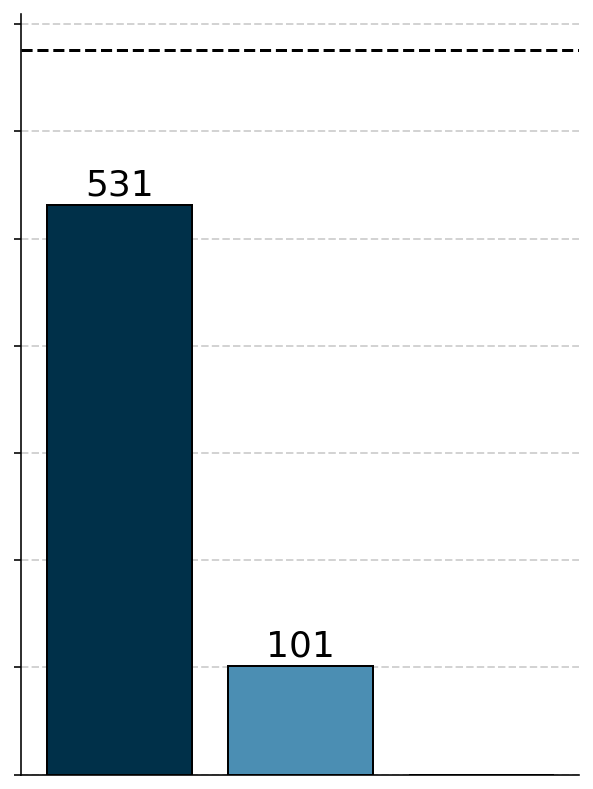

In [61]:
barplot("family", "Filoviridae")

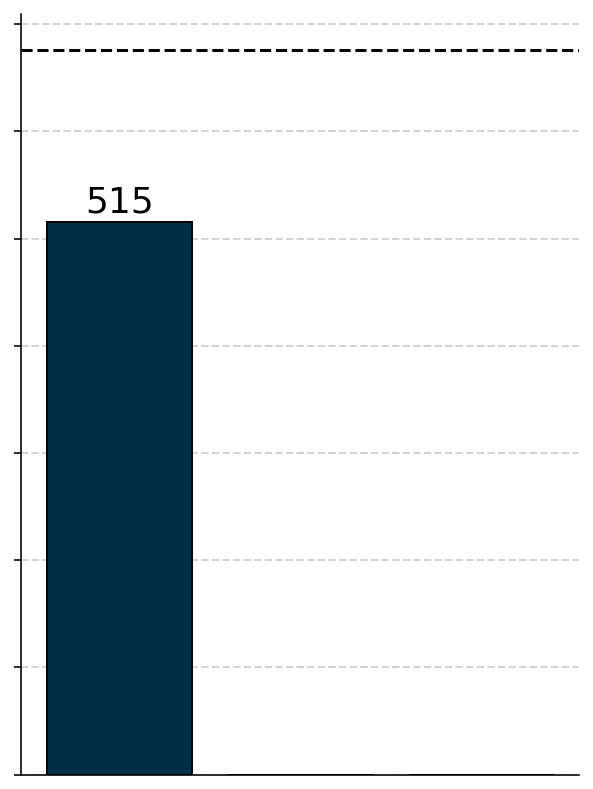

In [62]:
barplot("genus", "Ebolavirus")

In [63]:
def barplot_incorrects(tax_level, expected_tax):
    fig, ax = plt.subplots(figsize=(5,7))
    fontsize=18

    correct = adata2[:, adata2.var.index.isin(taxmap[taxmap[tax_level].isin(expected_tax)]["rep_ID"].unique())].X.sum()
    ax.bar(0, correct, color=colors[0], edgecolor="black")
    if correct > 0:
        ax.text(0, correct+10, str(int(correct)), fontsize=fontsize, ha="center")


    correct = adata[:, adata.var.index.isin(taxmap[taxmap[tax_level].isin(expected_tax)]["rep_ID"].unique())].X.sum()
    ax.bar(1, correct, color=colors[1], edgecolor="black")
    if correct > 0:
        ax.text(1, correct+10, str(int(correct)), fontsize=fontsize, ha="center")

    correct = adata3[:, adata3.var.index.isin(taxmap[taxmap[tax_level].isin(expected_tax)]["rep_ID"].unique())].X.sum()
    ax.bar(2, correct, color=colors[2], edgecolor="black")
    if correct > 0:
        ax.text(2, correct+10, str(int(correct)), fontsize=fontsize, ha="center")
    
    ax.axhline(total, color="black", ls="--")

    # x_labels = ["All Ebolavirus\nspecies excluded", "All Ebolavirus\ngenera excluded", "All Filoviridae\nexcluded"]
    # ax.set_xticks([0,1,2], x_labels)
    ax.set_xticks([])
    
    if tax_level == "phylum":
        ax.set_ylabel("Counts", fontsize=fontsize)
    else:
        ax.set_yticks([0,100,200,300,400,500,600,700], ["","","","","","","",""])
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.tick_params(axis="both", labelsize=fontsize)

    ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
    ax.set_axisbelow(True)

    plt.savefig(f"figures/targets_removed_offtarget_{tax_level}_{expected_tax[0]}.png", dpi=300, bbox_inches="tight")

    fig.show()

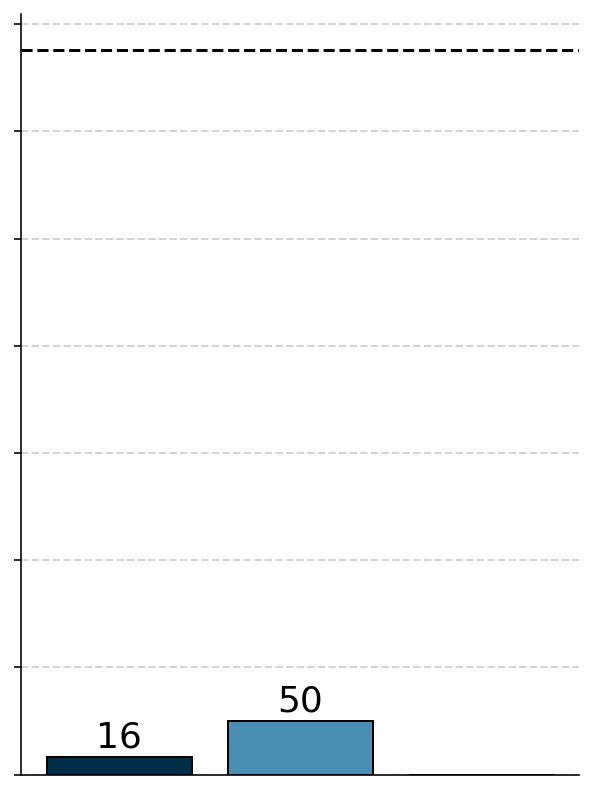

In [64]:
barplot_incorrects("species", ["Marburg marburgvirus"])

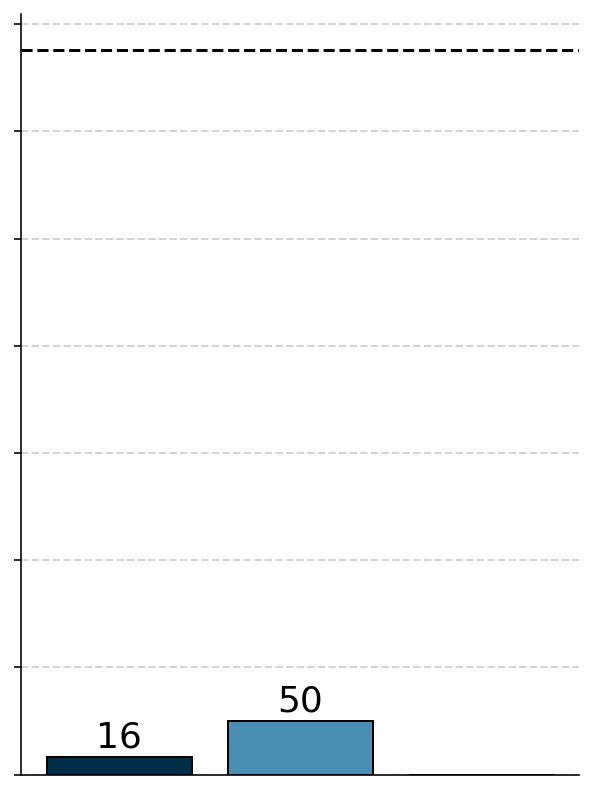

In [65]:
barplot_incorrects("genus", ["Marburgvirus"])

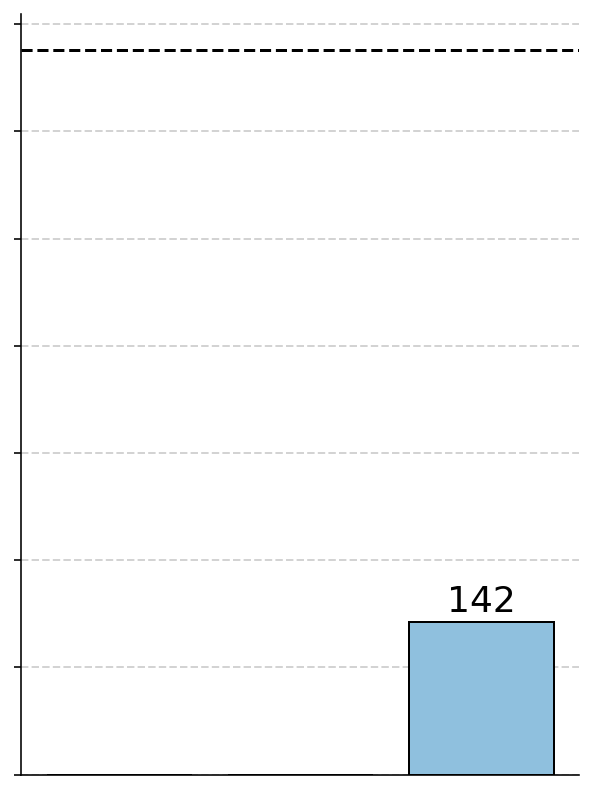

In [66]:
barplot_incorrects("family", ["Paramyxoviridae"])

In [67]:
def barplot_incorrects2(tax_level1, expected_tax1, tax_level2, expected_tax2):
    fig, ax = plt.subplots(figsize=(5,7))
    fontsize=18

    correct = adata2[:, adata2.var.index.isin(taxmap[(taxmap[tax_level1].isin(expected_tax1)) & (taxmap[tax_level2].isin(expected_tax2))]["rep_ID"].unique())].X.sum()
    ax.bar(0, correct, color=colors[0], edgecolor="black")
    if correct > 0:
        ax.text(0, correct+10, str(int(correct)), fontsize=fontsize, ha="center")


    correct = adata[:, adata.var.index.isin(taxmap[(taxmap[tax_level1].isin(expected_tax1)) & (taxmap[tax_level2].isin(expected_tax2))]["rep_ID"].unique())].X.sum()
    ax.bar(1, correct, color=colors[1], edgecolor="black")
    if correct > 0:
        ax.text(1, correct+10, str(int(correct)), fontsize=fontsize, ha="center")

    correct = adata3[:, adata3.var.index.isin(taxmap[(taxmap[tax_level1].isin(expected_tax1)) & (taxmap[tax_level2].isin(expected_tax2))]["rep_ID"].unique())].X.sum()
    ax.bar(2, correct, color=colors[2], edgecolor="black")
    if correct > 0:
        ax.text(2, correct+10, str(int(correct)), fontsize=fontsize, ha="center")
    
    ax.axhline(total, color="black", ls="--")

    # x_labels = ["All Ebolavirus\nspecies excluded", "All Ebolavirus\ngenera excluded", "All Filoviridae\nexcluded"]
    # ax.set_xticks([0,1,2], x_labels)
    ax.set_xticks([])
    
    ax.set_yticks([0,100,200,300,400,500,600,700], ["","","","","","","",""])
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.tick_params(axis="both", labelsize=fontsize)

    ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
    ax.set_axisbelow(True)

    plt.savefig(f"figures/targets_removed_offtarget_{tax_level1}_{tax_level2}.png", dpi=300, bbox_inches="tight")

    fig.show()

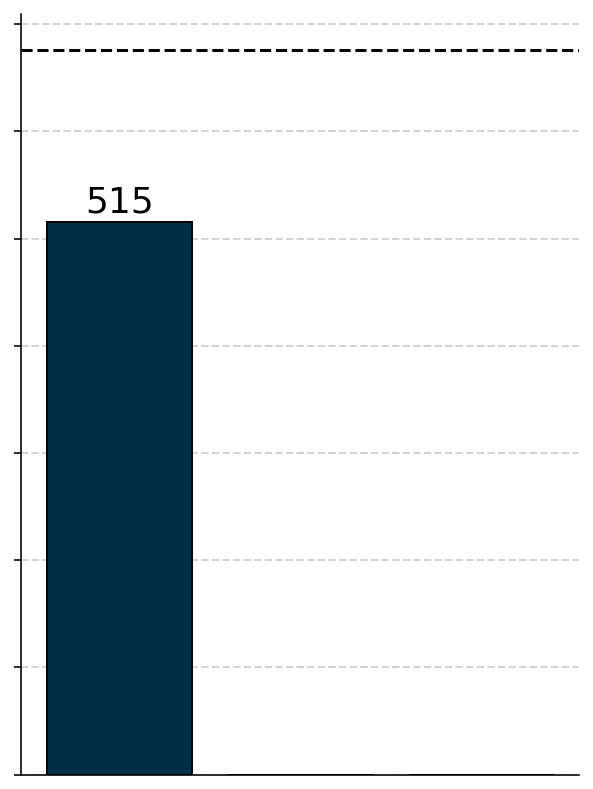

In [68]:
barplot_incorrects2("genus", ["Ebolavirus"], "species", ["."])

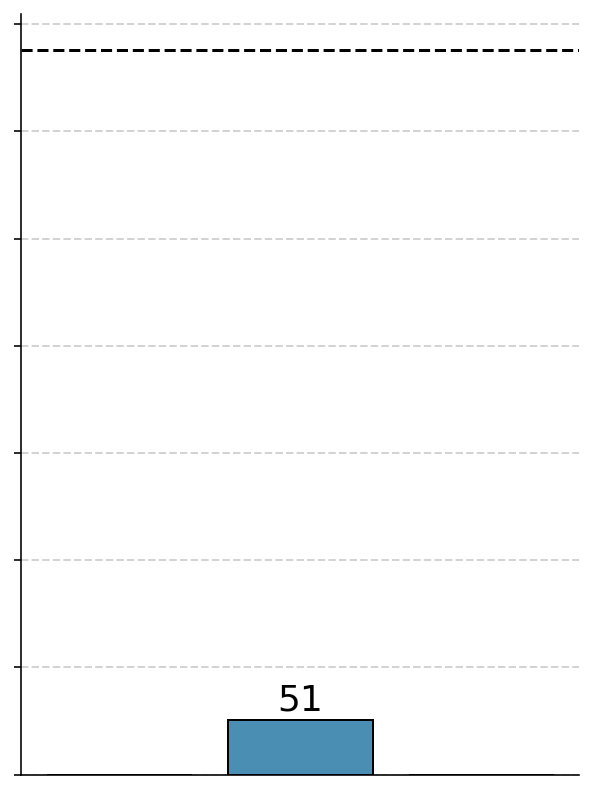

In [69]:
barplot_incorrects2("genus", ["."], "species", ["."])

In [70]:
# # Create legend
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt

# fig,ax = plt.subplots(figsize=(7,7))
# fontsize=14

# c_patch = mpatches.Patch(facecolor='white', edgecolor="black", label='Correct')
# i_patch = mpatches.Patch(facecolor='white', edgecolor="black", hatch="++", label="Incorrect")
# m_patch = mpatches.Patch(facecolor='white', edgecolor="black", hatch="//", label="Multimapped")
# ax.legend(handles=[c_patch, i_patch, m_patch], fontsize=fontsize)

# plt.savefig(f"figures/targets_removed_legend.png", dpi=300, bbox_inches="tight")

# fig.show()

# Plot tree

In [360]:
def df_to_dict(df):
    """
    Convert data frame to node_to_children dictionary as a first step to converting it to Newick format. 
    
    Every row in the data frame (df) should stand for one complete branch of the tree from the root to the leaves in order
    from left to right. 
    
    Returns formatted dictionary.
    
    Source:
    https://stackoverflow.com/questions/65017040/how-to-convert-pandas-dataframe-to-dictionary-for-newick-format
    """
    node_to_children = {}

    # Setting arbritrary branch length 1
    branch_length = 1

    # Iterate over dataframe row-wise, assuming that every row stands for one complete branch of the tree
    for row in df.itertuples():
        # Remove index at position 0 and elements that contain no child (".")
        row_list = [element for element in row[1:] if element != "."]

        for i in range(len(row_list)-1):
            if row_list[i] in node_to_children.keys():
                # Check if parent entry already existing 
                if row_list[i+1] in node_to_children[row_list[i]].keys():
                    # If already exists --> next
                    continue
                else:
                    # If entry does not exist --> update dict and add the connection
                    node_to_children[row_list[i]].update({row_list[i+1]:branch_length})
            else:
                # Add the branching point
                node_to_children[row_list[i]] = {row_list[i+1]:branch_length}
    
    return node_to_children


def newickify(node_to_children, root_node) -> str:
    """
    Function to convert a dictionary to Newick format.
    
    Source:
    https://stackoverflow.com/questions/50003007/how-to-convert-python-dictionary-to-newick-form-format
    """
    # Setting arbritrary branch length 1
    branch_length = 1
    
    visited_nodes = set()

    def newick_render_node(name, distance: float) -> str:
        assert name not in visited_nodes, "Error: The tree may not be circular!"

        if name not in node_to_children:
            # Leafs
            return F'{name}:{distance}'
        else:
            # Nodes
            visited_nodes.add(name)
            children = node_to_children[name]
            children_strings = [newick_render_node(child, children[child]) for child in children.keys()]
            children_strings = ",".join(children_strings)
            return F'({children_strings}){name}:{distance}'

    newick_string = newick_render_node(root_node, branch_length) + ';'

    # Ensure no entries in the dictionary were left unused
    assert visited_nodes == set(node_to_children.keys()), "Error: some nodes aren't in the tree"

    return newick_string

In [361]:
# Combine phylogenies returned by both conditions
t1 = taxmap[taxmap["rep_ID"].isin(ids_seen)].drop(["ID", "rep_ID", "strandedness"], axis=1).drop_duplicates()
t2 = taxmap[taxmap["rep_ID"].isin(ids_seen2)].drop(["ID", "rep_ID", "strandedness"], axis=1).drop_duplicates()
t3 = taxmap[taxmap["rep_ID"].isin(["u10"])].drop(["ID", "rep_ID", "strandedness"], axis=1).drop_duplicates()

In [362]:
# Add root node
final_df = t1.append(t2).append(t3)
final_df.insert(loc=0, column="realm", value="Riboviria")
final_df

,realm,phylum,class,order,family,genus,species
218192,Riboviria,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus
237814,Riboviria,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,.,.
32024,Riboviria,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,.
218192,Riboviria,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Marburgvirus,Marburg marburgvirus
409,Riboviria,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus


In [363]:
# Convert to Newick format
n_string = newickify(df_to_dict(final_df), "Riboviria")
n_string

'((((((Marburg marburgvirus:1)Marburgvirus:1,(Zaire ebolavirus:1)Ebolavirus:1)Filoviridae:1)Mononegavirales:1)Monjiviricetes:1)Negarnaviricota:1)Riboviria:1;'

Plot tree:

In [364]:
from ete3 import Tree, faces, AttrFace, TreeStyle, NodeStyle
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

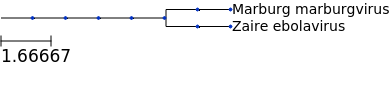

In [365]:
def layout(node):
    # If node is a leaf, add the nodes name and a its scientific name
    if node.is_leaf():
        faces.add_face_to_node(AttrFace("name"), node, column=0)

t = Tree(n_string, format=1)

# Node style handling is no longer limited to layout functions. You
# can now create fixed node styles and use them many times, save them
# or even add them to nodes before drawing (this allows to save and
# reproduce an tree image design)

# # Set bold red branch to the root node
# style = NodeStyle()
# style["fgcolor"] = "#0f0f0f"
# style["size"] = 0
# style["vt_line_color"] = "#ff0000"
# style["hz_line_color"] = "#ff0000"
# style["vt_line_width"] = 8
# style["hz_line_width"] = 8
# style["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
# style["hz_line_type"] = 0
# t.set_style(style)

# #Set dotted red lines to the first two branches
# style1 = NodeStyle()
# style1["fgcolor"] = "#0f0f0f"
# style1["size"] = 0
# style1["vt_line_color"] = "#ff0000"
# style1["hz_line_color"] = "#ff0000"
# style1["vt_line_width"] = 2
# style1["hz_line_width"] = 2
# style1["vt_line_type"] = 2 # 0 solid, 1 dashed, 2 dotted
# style1["hz_line_type"] = 2
# t.children[0].img_style = style1
# t.children[1].img_style = style1

# # Set dashed blue lines in all leaves
# style2 = NodeStyle()
# style2["fgcolor"] = "#000000"
# style2["shape"] = "circle"
# style2["vt_line_color"] = "#0000aa"
# style2["hz_line_color"] = "#0000aa"
# style2["vt_line_width"] = 2
# style2["hz_line_width"] = 2
# style2["vt_line_type"] = 1 # 0 solid, 1 dashed, 2 dotted
# style2["hz_line_type"] = 1
# for l in t.iter_leaves():
#     l.img_style = style2

ts = TreeStyle()
ts.layout_fn = layout
ts.show_leaf_name = False

t.render("%%inline", tree_style=ts)